In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [2]:
emd_dim = 32
ae_gen = AutoEncTrainRoutine(emb_dim=emd_dim)

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [3]:
poll = 1

In [4]:
model_name = f"poll{poll}_lstmae_180_embed{emd_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path=f"data/poll{poll}_normal_train_180.csv", val_ds_path=f"data/poll{poll}_normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

loading AE model from models/poll1_lstmae_180_embed32.pth


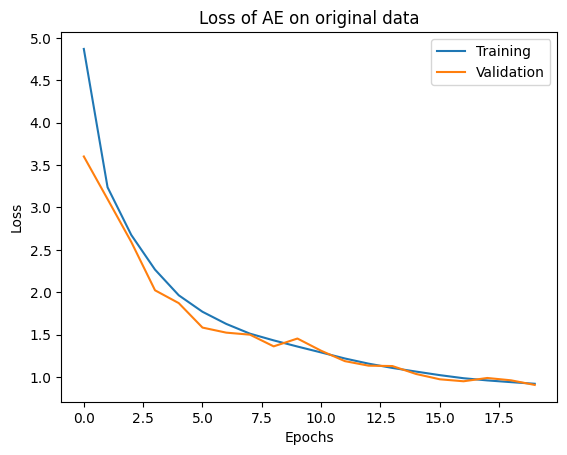

In [10]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title(f"Loss of AE on polluted original data with {poll}% polluted data")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [5]:
window_size=180
evaluator = Evaluator(val_normal_path=f"data/poll{poll}_normal_val_{window_size}.csv",
                      val_anomaly_path=f"data/poll{poll}_anomalie_val_{window_size}.csv",
                        test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


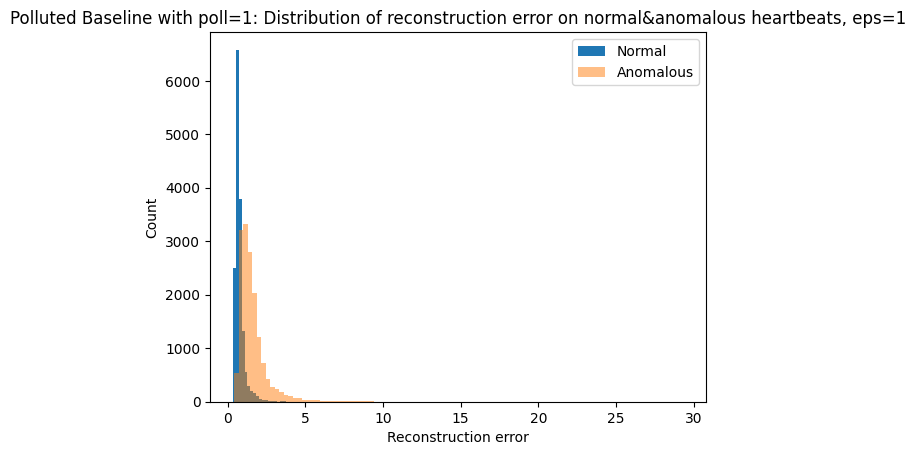

In [6]:
plt.figure()

plt.hist(evaluator.loss_val_normal, bins=100)

plt.title(f"Polluted Baseline with poll={poll}: Distribution of reconstruction error on normal&anomalous heartbeats, eps=1")

plt.hist(evaluator.loss_val_anomaly, bins=100, alpha=0.5)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")

plt.legend(["Normal", "Anomalous"])

plt.show()

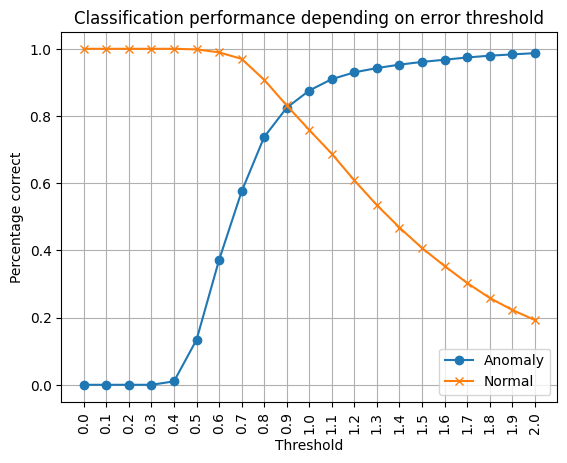

In [7]:
thres_l = np.linspace(0,2,21)
corr_normal, corr_anomaly = evaluator.find_threshold(thres_l)
plt.plot(thres_l, corr_normal, marker="o")
plt.plot(thres_l, corr_anomaly, marker="x")
plt.xticks(thres_l, rotation=90)
plt.grid()
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.title("Classification performance depending on error threshold")
plt.show()

In [9]:
predictions_normal, predictions_anomaly = evaluator.predict_class(0.9)


In [10]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 1469
FN: 291
FP: 287
TN: 1517
Acc: 0.8378226711560045
Precision: 0.8390486725663717
Recall: 0.8409090909090909
F1: 0.8399778516057586
Formatted (acc, prec, rec, f1):
0.8378226711560045,0.8390486725663717, 0.8409090909090909, 0.8399778516057586
